In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import keras_tuner as kt

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
PATH = "Dataset"
MODEL = "InceptionV3"

In [3]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 7560 files belonging to 4 classes.


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 3240 files belonging to 4 classes.


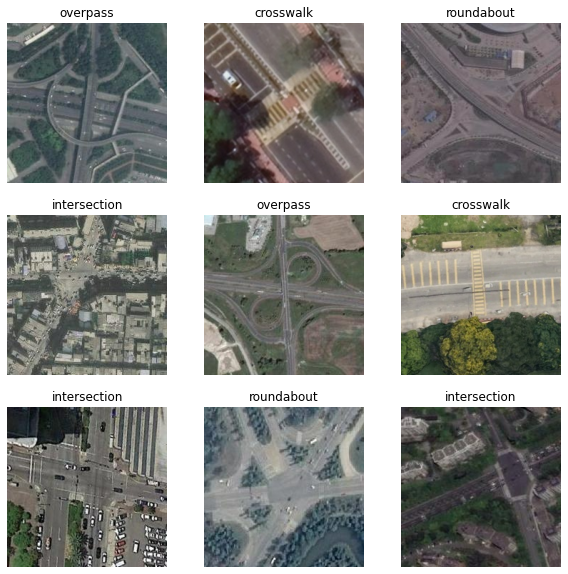

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 3)
validation_dataset = validation_dataset.skip(val_batches // 3)

In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 68
Number of test batches: 34


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

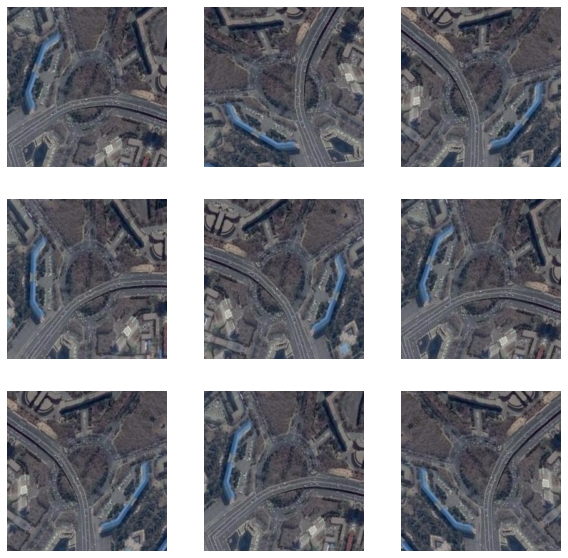

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [12]:
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [13]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(input_shape=(224,224,3),
                         include_top=False, 
                         weights="imagenet")

base_model.trainable=True
# trainable_at = int(len(base_model.layers)/3)

# # freeze 1/3 of the layers
# for layer in base_model.layers[:trainable_at]: 
#     layer.trainable=False

In [14]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [16]:
# Create InceptionV3 model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, Flatten, InputLayer
from tensorflow.keras.applications import InceptionV3


class InceptionV3HyperModel(kt.HyperModel): 

    # Create class for hyperparameter tuning
    def build(self, hp): 

        base_model = InceptionV3(input_shape=(224,224,3),
                                include_top=False, 
                                weights="imagenet")

        base_model.trainable=True

        inputs = tf.keras.Input(shape=(224, 224, 3))
        x = preprocess_input(inputs)
        x = base_model(x, training=True)
        x = global_average_layer(x)
        x = Dense(256, activation="relu", kernel_initializer='he_uniform')(x)
        x = Dropout(0.2)(x)
        x = Dense(32, activation="relu", kernel_initializer='he_uniform')(x)
        x = Dropout(0.2)(x)
        outputs = Dense(4, activation='softmax', kernel_initializer='he_uniform')(x)
        model = tf.keras.Model(inputs, outputs)

        # Tune the learning rate for the optimizer
        # Choose an optimal value from 0.01, 0.001, or 0.0001
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        # compile model
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'])

        return model
    
    def fit(self, hp, model, *args, **kwargs): 
        return model.fit(
            *args, 
            batch_size=hp.Choice("batch_size", [32, 64]),
            **kwargs
        )

In [17]:
tuner = kt.GridSearch(
    InceptionV3HyperModel(), 
    objective="val_accuracy", 
    seed=0, 
    directory=MODEL, 
    project_name=MODEL
)

In [18]:
# logging to tensorboard

from datetime import datetime

log_dir = f"logs/fit/{MODEL}_" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [19]:
tuner.search(train_dataset,
             epochs=50,
             validation_data=validation_dataset, 
             callbacks=[tensorboard_callback], 
             use_multiprocessing=True)

Trial 6 Complete [00h 18m 41s]
val_accuracy: 0.9897769689559937

Best val_accuracy So Far: 0.9897769689559937
Total elapsed time: 01h 52m 00s
INFO:tensorflow:Oracle triggered exit


In [20]:
best_model = tuner.get_best_models(1)[0]
best_model.build(input_shape=(224,224,3))
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [21]:
tuner.results_summary()

Results summary
Results in InceptionV3/InceptionV3
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0005 summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 64
Score: 0.9897769689559937

Trial 0004 summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 32
Score: 0.9879181981086731

Trial 0003 summary
Hyperparameters:
learning_rate: 0.001
batch_size: 64
Score: 0.9795538783073425

Trial 0002 summary
Hyperparameters:
learning_rate: 0.001
batch_size: 32
Score: 0.9749070405960083

Trial 0000 summary
Hyperparameters:
learning_rate: 0.01
batch_size: 32
Score: 0.25464683771133423

Trial 0001 summary
Hyperparameters:
learning_rate: 0.01
batch_size: 64
Score: 0.2523234188556671


In [22]:
loss, accuracy = best_model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

34/34 [==============================] - 3s 32ms/step - loss: 0.1022 - accuracy: 0.9816
Test accuracy : 0.9816176295280457


34/34 [==============================] - 1s 32ms/step - loss: 0.1061 - accuracy: 0.9770
Test accuracy : 0.9770220518112183
Predictions:
 [2, 2, 1, 3, 3, 1, 3, 0, 0, 3, 2, 2, 2, 1, 1, 3, 3, 3, 2, 2, 3, 3, 1, 1, 0, 0, 3, 0, 1, 1, 2, 1]
Labels:
 [2 2 1 3 3 1 3 0 0 3 2 2 2 1 1 3 3 3 2 2 3 3 1 1 0 0 3 0 2 1 2 1]


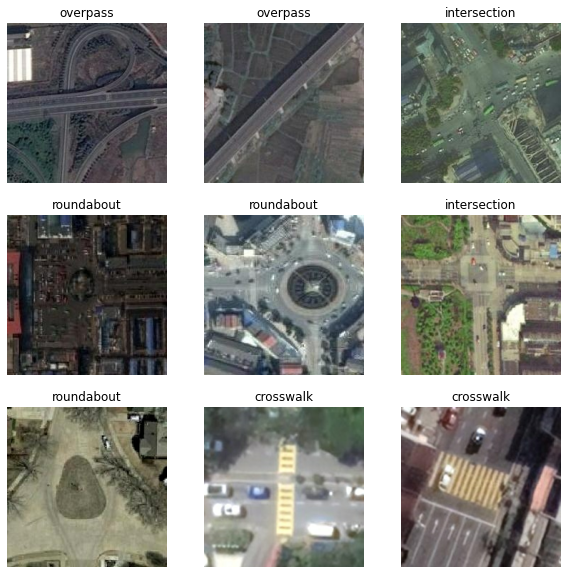

In [23]:
loss, accuracy = best_model.evaluate(test_dataset)
print('Test accuracy :', accuracy)
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = best_model.predict_on_batch(image_batch)

prediction_label = []
for prediction in predictions: 
    pred = max(prediction)
    prediction_label.append(prediction.tolist().index(pred))

# # Apply a sigmoid since our model returns logits
# predictions = tf.nn.sigmoid(predictions)
# predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', prediction_label)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[prediction_label[i]])
  plt.axis("off")